<a href="https://colab.research.google.com/github/adlihs/instatXML/blob/main/Instat_%7C_Pass_Map_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mplsoccer
!pip install -U pandasql
!pip install highlight-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for mplsoccer: filename=mplsoccer-1.1.2-py3-none-any.whl size=68817 sha256=c7965c6de776b0e57464a126c8df4d1041be31038fc70f0bfda32b39e31c4fa7
  Stored in directory: /root/.cache/pip/wheels/b0/9e/9e/8687b72ac1200fdc0d874825fee42402b314305f7d548a888e
Successfully built mplsoccer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=0b216e0960473c9b6e9bd972f1f98e8123e725d8e8d3005fef6f0de7c09a56ab
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup pandasql

In [3]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Import packages

In [4]:
import os, sys 
#to be able to interact with Google Drive's operating system
from google.colab import drive 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from urllib.request import urlopen
from PIL import Image
from mplsoccer import Pitch,VerticalPitch, FontManager, Sbopen, add_image
from highlight_text import ax_text

## Load fonts

In [225]:
import matplotlib as mpl
import matplotlib.font_manager as fm

#!mv /content/drive/MyDrive/fonts/Comfortaa-Bold.ttf /usr/share/fonts/truetype/

path = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf' #'/usr/share/fonts/truetype/Oswald-Bold.ttf'
fontprop = fm.FontProperties(fname=path, size= 35)
game_det_fontprop = fm.FontProperties(fname=path, size=20)
title_det_fontprop = fm.FontProperties(fname=path, size=15)


## Load Instat data

In [7]:
%cd '/content/drive/MyDrive/SIFUTCR'

main_df = pd.read_parquet('UNAFUT.parquet')
main_df.query("Acciones != 'Ataques posicionales'",inplace=True) 
main_df.head()

/content/drive/MyDrive/SIFUTCR


,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,...,nombre_torneo,equipo_casa,equipo_visita,marcador,goles_local,goles_visita,rival,marcador_casa,marcador_visita,detalle_marcador
1,2,7.730469,27.73,52.2,35.2,Perez-Zeledon-1-1-Municipal-Grecia,88,Starling Matarrita Gonzalez,Perez Zeledon,Pases precisos,...,Clausura 2022,Perez Zeledon,Municipal Grecia,1-1,1,1,Municipal Grecia,0.0,0.0,0-0
3,4,8.523438,28.52,37.9,34.4,Perez-Zeledon-1-1-Municipal-Grecia,20,Nestor Monge Guevara,Perez Zeledon,Pases precisos,...,Clausura 2022,Perez Zeledon,Municipal Grecia,1-1,1,1,Municipal Grecia,0.0,0.0,0-0
5,6,10.523438,30.52,25.4,54.4,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,...,Clausura 2022,Perez Zeledon,Municipal Grecia,1-1,1,1,Municipal Grecia,0.0,0.0,0-0
7,8,13.140625,33.14,17.7,44.2,Perez-Zeledon-1-1-Municipal-Grecia,55,Chistian Antonio Reyes Aleman,Perez Zeledon,Pases precisos,...,Clausura 2022,Perez Zeledon,Municipal Grecia,1-1,1,1,Municipal Grecia,0.0,0.0,0-0
9,11,19.796875,39.79,20.4,54.9,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,...,Clausura 2022,Perez Zeledon,Municipal Grecia,1-1,1,1,Municipal Grecia,0.0,0.0,0-0


## Get teams starting lineups by game

In [8]:
def get_lineups(instat_data):
  main_df = instat_data
  '''
  Process to identify the startup lineup by games and teams
  '''
  # Get the minimum ID of player's action
  #query = "SELECT  Partido, Equipos, camisa, jugador, min(ID) as 'min_id' FROM main_df WHERE Partido = '{}' GROUP BY Partido, Equipos, camisa, jugador".format(game)
  query = "SELECT  Partido, Equipos, camisa, jugador, min(ID) as 'min_id' FROM main_df GROUP BY Partido, Equipos, camisa, jugador"
  lineup_df = pysqldf(query) 
  lineup_df['min_id'] = pd.to_numeric(lineup_df['min_id'])
  
  #Get the list of games
  partidos = lineup_df['Partido'].unique()


  lineups_data = pd.DataFrame()
  for game in partidos:
    temp_df = lineup_df.query("Partido == @game")
    teams_temp_df = temp_df['Equipos'].unique()
    for teams in teams_temp_df:
      temp_df = lineup_df.query("Partido == @game and Equipos == @teams")
      temp_lineup = temp_df.nsmallest(n=11, columns=['min_id'], keep='last')
      lineups_data = lineups_data.append(temp_lineup) 
  return lineups_data

## Filter main dataframe with important columns

In [9]:
pass_df = main_df[['ID','start','end','pos_x','pos_y','Partido','camisa','jugador','Equipos','Acciones']]
pass_df.head()

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones
1,2,7.730469,27.73,52.2,35.2,Perez-Zeledon-1-1-Municipal-Grecia,88,Starling Matarrita Gonzalez,Perez Zeledon,Pases precisos
3,4,8.523438,28.52,37.9,34.4,Perez-Zeledon-1-1-Municipal-Grecia,20,Nestor Monge Guevara,Perez Zeledon,Pases precisos
5,6,10.523438,30.52,25.4,54.4,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos
7,8,13.140625,33.14,17.7,44.2,Perez-Zeledon-1-1-Municipal-Grecia,55,Chistian Antonio Reyes Aleman,Perez Zeledon,Pases precisos
9,11,19.796875,39.79,20.4,54.9,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos


## Remove actions with the same (x,y) position as passes and assists

In [10]:
# Identify x,y for passes and assists
duplicate_pass_location = pysqldf("SELECT distinct ID,pos_x, pos_y from pass_df WHERE Acciones in ('Pases precisos','Asistencias')")

duplicates_id = pysqldf("SELECT distinct a.ID,a.pos_x,a.pos_y from pass_df A inner join duplicate_pass_location B ON a.pos_x = b.pos_x and a.pos_y = b.pos_y WHERE A.Acciones not in ('Pases precisos','Asistencias') ")

#pass_df = pysqldf("SELECT * FROM pass_df WHERE ([ID],pos_x,pos_y) NOT IN (SELECT [ID],pos_x,pos_y FROM duplicates_id) ")

pass_df = pysqldf("SELECT A.* FROM pass_df A  LEFT JOIN duplicates_id B ON A.ID = B.ID and A.pos_x = B.pos_x and A.pos_y = B.pos_y WHERE B.ID is null ")
pass_df.head()

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones
0,2,7.730469,27.73,52.2,35.2,Perez-Zeledon-1-1-Municipal-Grecia,88,Starling Matarrita Gonzalez,Perez Zeledon,Pases precisos
1,4,8.523438,28.52,37.9,34.4,Perez-Zeledon-1-1-Municipal-Grecia,20,Nestor Monge Guevara,Perez Zeledon,Pases precisos
2,6,10.523438,30.52,25.4,54.4,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos
3,8,13.140625,33.14,17.7,44.2,Perez-Zeledon-1-1-Municipal-Grecia,55,Chistian Antonio Reyes Aleman,Perez Zeledon,Pases precisos
4,11,19.796875,39.79,20.4,54.9,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos


## Setup the `end` columns (x,y,jugadores,equipos,acciones)

In [11]:
pass_df['pos_x_end'] = pass_df['pos_x'].shift(-1)
pass_df['pos_y_end'] = pass_df['pos_y'].shift(-1)
pass_df['jugador_end'] = pass_df['jugador'].shift(-1)
pass_df['camisa_end'] = pass_df['camisa'].shift(-1)
pass_df['equipos_end'] = pass_df['Equipos'].shift(-1)
pass_df['acciones_end'] = pass_df['Acciones'].shift(-1)
pass_df.head()

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,pos_x_end,pos_y_end,jugador_end,camisa_end,equipos_end,acciones_end
0,2,7.730469,27.73,52.2,35.2,Perez-Zeledon-1-1-Municipal-Grecia,88,Starling Matarrita Gonzalez,Perez Zeledon,Pases precisos,37.9,34.4,Nestor Monge Guevara,20,Perez Zeledon,Pases precisos
1,4,8.523438,28.52,37.9,34.4,Perez-Zeledon-1-1-Municipal-Grecia,20,Nestor Monge Guevara,Perez Zeledon,Pases precisos,25.4,54.4,Mauricio de Jesus Nunez Morales,23,Perez Zeledon,Pases precisos
2,6,10.523438,30.52,25.4,54.4,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,17.7,44.2,Chistian Antonio Reyes Aleman,55,Perez Zeledon,Pases precisos
3,8,13.140625,33.14,17.7,44.2,Perez-Zeledon-1-1-Municipal-Grecia,55,Chistian Antonio Reyes Aleman,Perez Zeledon,Pases precisos,20.4,54.9,Mauricio de Jesus Nunez Morales,23,Perez Zeledon,Pases precisos
4,11,19.796875,39.79,20.4,54.9,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,21.4,31.1,Jussef Nelson Delgado Lopez,22,Perez Zeledon,Pases precisos


## Select only passes and assists

In [12]:
onlyPasses = pass_df.query("Acciones in ('Pases precisos','Asistencias')") 
onlyPasses.head(5)

,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,pos_x_end,pos_y_end,jugador_end,camisa_end,equipos_end,acciones_end
0,2,7.730469,27.73,52.2,35.2,Perez-Zeledon-1-1-Municipal-Grecia,88,Starling Matarrita Gonzalez,Perez Zeledon,Pases precisos,37.9,34.4,Nestor Monge Guevara,20,Perez Zeledon,Pases precisos
1,4,8.523438,28.52,37.9,34.4,Perez-Zeledon-1-1-Municipal-Grecia,20,Nestor Monge Guevara,Perez Zeledon,Pases precisos,25.4,54.4,Mauricio de Jesus Nunez Morales,23,Perez Zeledon,Pases precisos
2,6,10.523438,30.52,25.4,54.4,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,17.7,44.2,Chistian Antonio Reyes Aleman,55,Perez Zeledon,Pases precisos
3,8,13.140625,33.14,17.7,44.2,Perez-Zeledon-1-1-Municipal-Grecia,55,Chistian Antonio Reyes Aleman,Perez Zeledon,Pases precisos,20.4,54.9,Mauricio de Jesus Nunez Morales,23,Perez Zeledon,Pases precisos
4,11,19.796875,39.79,20.4,54.9,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,21.4,31.1,Jussef Nelson Delgado Lopez,22,Perez Zeledon,Pases precisos


## Select passes where `Equipos` is equal to `equipos_end`.
With this filter we ensure that the player makes a pass to a team player

In [13]:
onlyPasses.query("Equipos == equipos_end", inplace=True)
onlyPasses.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,start,end,pos_x,pos_y,Partido,camisa,jugador,Equipos,Acciones,pos_x_end,pos_y_end,jugador_end,camisa_end,equipos_end,acciones_end
0,2,7.730469,27.73,52.2,35.2,Perez-Zeledon-1-1-Municipal-Grecia,88,Starling Matarrita Gonzalez,Perez Zeledon,Pases precisos,37.9,34.4,Nestor Monge Guevara,20,Perez Zeledon,Pases precisos
1,4,8.523438,28.52,37.9,34.4,Perez-Zeledon-1-1-Municipal-Grecia,20,Nestor Monge Guevara,Perez Zeledon,Pases precisos,25.4,54.4,Mauricio de Jesus Nunez Morales,23,Perez Zeledon,Pases precisos
2,6,10.523438,30.52,25.4,54.4,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,17.7,44.2,Chistian Antonio Reyes Aleman,55,Perez Zeledon,Pases precisos
3,8,13.140625,33.14,17.7,44.2,Perez-Zeledon-1-1-Municipal-Grecia,55,Chistian Antonio Reyes Aleman,Perez Zeledon,Pases precisos,20.4,54.9,Mauricio de Jesus Nunez Morales,23,Perez Zeledon,Pases precisos
4,11,19.796875,39.79,20.4,54.9,Perez-Zeledon-1-1-Municipal-Grecia,23,Mauricio de Jesus Nunez Morales,Perez Zeledon,Pases precisos,21.4,31.1,Jussef Nelson Delgado Lopez,22,Perez Zeledon,Pases precisos


## Count passes between players by games

In [14]:
pass_count_players = pysqldf("SELECT Partido, Equipos, jugador, camisa, equipos_end, jugador_end,camisa_end,count(*) 'cantidad_pases' from onlyPasses group by Partido,Equipos, jugador, camisa, equipos_end,jugador_end,camisa_end")
pass_count_players.head()

,Partido,Equipos,jugador,camisa,equipos_end,jugador_end,camisa_end,cantidad_pases
0,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Alex Lopez Rodrigues,11,3
1,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Alexis Gamboa,13,2
2,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Bernald Alfaro Alfaro,26,5
3,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Bryan Ruiz,10,2
4,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Carlos Andrei Mora Montoya,17,2


## Average Position players by Games

In [15]:
players_avg_position = pysqldf("SELECT Partido,Equipos,jugador, camisa, avg(pos_x) as 'avg_pos_x', avg(pos_y) as 'avg_pos_y' FROM  main_df WHERE Acciones in ('Pases precisos','Asistencias') GROUP BY Partido,Equipos,jugador, camisa ")
players_avg_position.head()



,Partido,Equipos,jugador,camisa,avg_pos_x,avg_pos_y
0,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,64.322857,28.845714
1,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Alex Lopez Rodrigues,11,53.467568,38.543243
2,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Alexis Gamboa,13,35.076712,45.739726
3,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Bernald Alfaro Alfaro,26,47.666667,26.127273
4,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Bryan Ruiz,10,54.992000,45.630000


In [16]:
start11 = get_lineups(main_df)

#Only 11 startup
players_avg_position = pd.merge(players_avg_position, start11, on=["Partido","Equipos","jugador","camisa"])

## Add avg position columns to `pass_count_players` dataframe

In [17]:
# Average position columns for 'jugador'
pass_count_players = pysqldf("SELECT A.*, B.avg_pos_x as 'jugador_avg_pos_x', B.avg_pos_y as 'jugador_avg_pos_y' FROM pass_count_players A LEFT JOIN players_avg_position B on A.Partido = B.Partido and A.jugador = B.jugador and A.camisa = B.camisa and A.Equipos = B.Equipos")
# Average position columns for 'jugador_end'
pass_count_players = pysqldf("SELECT A.*, B.avg_pos_x as 'jugador_end_avg_pos_x', B.avg_pos_y as 'jugador_end_avg_pos_y' FROM pass_count_players A LEFT JOIN players_avg_position B on A.Partido = B.Partido and A.jugador_end = B.jugador and A.camisa_end = B.camisa and A.Equipos = B.Equipos")

pass_count_players.head()

,Partido,Equipos,jugador,camisa,equipos_end,jugador_end,camisa_end,cantidad_pases,jugador_avg_pos_x,jugador_avg_pos_y,jugador_end_avg_pos_x,jugador_end_avg_pos_y
0,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Alex Lopez Rodrigues,11,3,64.322857,28.845714,NaN,NaN
1,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Alexis Gamboa,13,2,64.322857,28.845714,35.076712,45.739726
2,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Bernald Alfaro Alfaro,26,5,64.322857,28.845714,47.666667,26.127273
3,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Bryan Ruiz,10,2,64.322857,28.845714,54.992000,45.630000
4,Alajuelense-0-1-Deportivo-Saprissa,Alajuelense,Aaron Suarez Zuniga,25,Alajuelense,Carlos Andrei Mora Montoya,17,2,64.322857,28.845714,65.009091,37.959091


## Create pass map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Text(0.5, -0.07, '  10. Bryan Ruiz   11. Alex Lopez Rodrigues   13. Alexis Gamboa \n  16. Yael Andres Lopez Fuentes   17. Carlos Andrei Mora Montoya \n  22. Giancarlo Gonzalez   25. Aaron Suarez Zuniga \n  26. Bernald Alfaro Alfaro   27. Ian Elijah Lawrence Escoe \n  35. Miguel Andres Aju Alfaro   4. Ian Rey Smith Quiros \n  8. Johan Venegas   9. Jurguens Josafat Montenegro Vallejo  ')

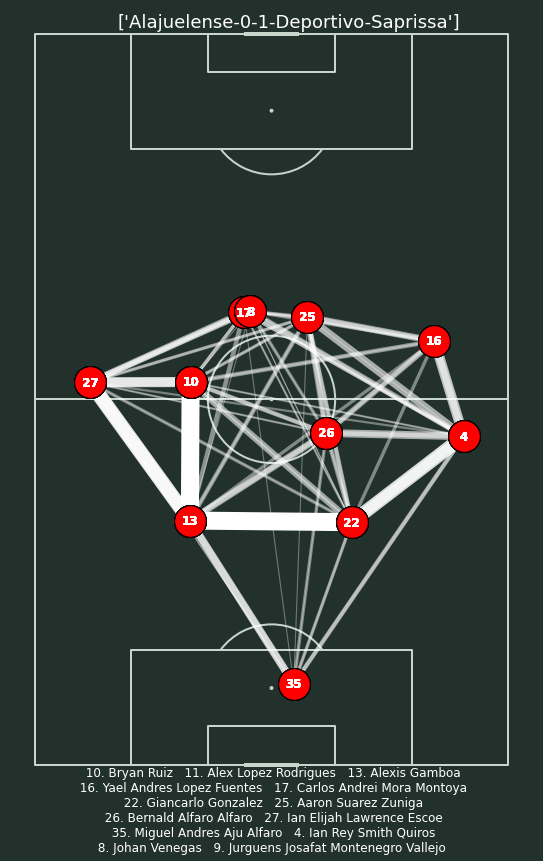

In [18]:
# Filter data for one game, and one team
pass_count_players_test = pass_count_players.query("Partido == 'Alajuelense-0-1-Deportivo-Saprissa' and Equipos == 'Alajuelense' ")

game = pass_count_players_test['Partido'].unique()
team = pass_count_players_test['Equipos'].unique()

# Calculate Line Width
pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
                           18)

# Name and shirt number
pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador

# Line colors
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(pass_count_players_test), 1))
c_transparency = pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency


# Main graph
pitch = VerticalPitch(pitch_type='custom',
              pitch_length=105,
              pitch_width=68,
              pitch_color='#22312b', 
              line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")
pass_lines = pitch.lines(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                         pass_count_players_test['jugador_end_avg_pos_x'], pass_count_players_test['jugador_end_avg_pos_y'],
                         lw=pass_count_players_test.width,
                         color=color, zorder=1, ax=ax)
pass_nodes = pitch.scatter(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                           s=1000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

# Put player number in markers
for index, row in pass_count_players_test.iterrows():
    pitch.annotate(row.camisa, xy=(row.jugador_avg_pos_x, row.jugador_avg_pos_y), c='white', va='center',
                   ha='center', size=12, weight='bold', ax=ax)

# List of players
players = pass_count_players_test[['full_name','camisa']]
players = players.sort_values(by=['camisa'],ascending=True)
players = players['full_name'].unique()
players_name = str(players)
players_name = players_name.replace('[',' ')
players_name = players_name.replace(']',' ')
players_name = players_name.replace("'",' ')

# add title
fig.text(
    0.515, 0.97, game, size=18,
    ha="center", color="white"
)

# add lineup
fig.text(
    0.50, -0.07, players_name, size=12,
    ha="center", color="white"
)



## Logo function

In [247]:
def set_logos(homeTeam,awayTeam):

  # Home team logo
  if homeTeam == 'Perez Zeledon':
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Perez.png")
    
  elif homeTeam == 'Municipal Grecia': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Grecia.png")
    
  elif homeTeam == 'Guadalupe': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Guadalupe.png")
    
  elif homeTeam == 'Cartagines': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Cartago.png")
    
  elif homeTeam == 'Alajuelense': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/lda.png")
    
  elif homeTeam == 'Herediano': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Heredia.png")
    
  elif homeTeam == 'San Carlos': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/San Carlos.png")
    
  elif homeTeam == 'Saprissa': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Saprissa.png")
    
  elif homeTeam == 'Sporting FC': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Sporting.png")
    
  elif homeTeam == 'Santos de Guapiles': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Santos.png")
    
  elif homeTeam == 'Guanacasteca': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/guana.png")
    
  elif homeTeam == 'Puntarenas': 
    image_home = Image.open("/content/drive/MyDrive/logos/Costa Rica/Puntarenas.png")
                     

  # Away team logo
  if awayTeam == 'Perez Zeledon':
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Perez.png")
    
  elif awayTeam == 'Municipal Grecia': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Grecia.png")
    
  elif awayTeam == 'Guadalupe': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Guadalupe.png")
    
  elif awayTeam == 'Cartagines': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Cartago.png")
    
  elif awayTeam == 'Alajuelense': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/lda.png")
    
  elif awayTeam == 'Herediano': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Heredia.png")
    
  elif awayTeam == 'San Carlos': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/San Carlos.png")
    
  elif awayTeam == 'Saprissa': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Saprissa.png")
  
  elif awayTeam == 'Sporting FC': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Sporting.png")
    
  elif awayTeam == 'Santos de Guapiles': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Santos.png")
    
  elif awayTeam == 'Guanacasteca': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/guana.png")
    
  elif awayTeam == 'Puntarenas': 
    image_away = Image.open("/content/drive/MyDrive/logos/Costa Rica/Puntarenas.png")
  
  
  return image_home,image_away                      

In [232]:
main_df.Equipos.unique()

array(['Perez Zeledon', 'Municipal Grecia', 'Guadalupe', 'Cartagines',
       'Alajuelense', 'Herediano', 'San Carlos', 'Saprissa',
       'Sporting FC', 'Jicaral', 'Santos de Guapiles', 'Guanacasteca'],
      dtype=object)

## Create pass network

In [257]:
def pass_maps(game,team1,team2):
  import re
  import warnings
  warnings.simplefilter("ignore", UserWarning)

  # Variables
  game = game
  team1 = team1
  team2 = team2

  game_details = main_df.query("Partido == @game")

  game_date = game_details['fecha_partido'].unique()
  home_team = game_details['equipo_casa'].unique()
  away_team = game_details['equipo_visita'].unique()
  final_result = game_details['marcador'].unique()
  tournament = game_details['nombre_torneo'].unique()

  # Clean variable strings
  game_date = str(game_date).replace('[', '').replace(']', '').replace("'",'')
  home_team = str(home_team).replace('[', '').replace(']', '').replace("'",'')
  away_team = str(away_team).replace('[', '').replace(']', '').replace("'",'')
  final_result = str(final_result).replace('[', '').replace(']', '').replace("'",'')
  tournament = str(tournament).replace('[', '').replace(']', '').replace("'",'')


  
  
  # Main graph
  pitch = VerticalPitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                pitch_color='#eee9e5', 
                line_color='#01161E')
  fig, axs = pitch.grid(figheight=14 ,ncols=2, axis=False, endnote_height=0.05,title_height=0.08,)
  fig.set_facecolor("#eee9e5")
  for idx, ax in enumerate(axs['pitch'].flat):
    if idx == 0:
      ######### TEAM 1 PASS MAP #########
      ax1 = ax
      # Filter data for one game, and one team
      pass_count_players_test = pass_count_players.query("Partido == @game and Equipos == @team1 ")

      # Line colors
      MIN_TRANSPARENCY = 0.3
      color = np.array(to_rgba('#6d6a69'))
      color = np.tile(color, (len(pass_count_players_test), 1))
      c_transparency = pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max()
      c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
      color[:, 3] = c_transparency


      # Calculate Line Width
      pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
                                18)

      # Name and shirt number
      pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador
      pass_lines = pitch.lines(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              pass_count_players_test['jugador_end_avg_pos_x'], pass_count_players_test['jugador_end_avg_pos_y'],
                              lw=pass_count_players_test.width,
                              color=color, zorder=1, ax=ax1)
      pass_nodes = pitch.scatter(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              s=1000, color='#eee9e5', edgecolors='#6d6a69', linewidth=1, alpha=1, ax=ax1)
      # Put player number in markers
      for index, row in pass_count_players_test.iterrows():
        pitch.annotate(row.camisa, xy=(row.jugador_avg_pos_x, row.jugador_avg_pos_y), c='#6d6a69', va='center',ha='center', size=11, ax=ax1)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game")
      
      #team1 = pass_count_players_test['Equipos'].unique()
      ax1.text(34, 110, team1, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################

      # List of players
      
      players = pass_count_players_test[['full_name','camisa','jugador_avg_pos_x']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')
      
      #query = "SELECT DISTINCT full_name FROM pass_count_players_test where jugador_avg_pos_x <> 'Nan' ORDER BY 1 asc"
      #players_name =  pysqldf(query) 

      axs['endnote'].text(0, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black')
      axs['endnote'].text(0, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 
    else:
      ######### TEAM 2 PASS MAP #########
      ax2 = ax

      # Filter data for one game, and one team
      pass_count_players_test = pass_count_players.query("Partido == @game and Equipos == @team2 ")

      # Line colors
      MIN_TRANSPARENCY = 0.3
      color = np.array(to_rgba('#6d6a69'))
      color = np.tile(color, (len(pass_count_players_test), 1))
      c_transparency = pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max()
      c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
      color[:, 3] = c_transparency



      game = pass_count_players_test['Partido'].unique()
      team = pass_count_players_test['Equipos'].unique()

      # Calculate Line Width
      pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
                                18)

      # Name and shirt number
      pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador
      pass_lines2 = pitch.lines(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              pass_count_players_test['jugador_end_avg_pos_x'], pass_count_players_test['jugador_end_avg_pos_y'],
                              lw=pass_count_players_test.width,
                              color=color, zorder=1, ax=ax2)
      pass_nodes2 = pitch.scatter(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              s=1000, color='#eee9e5', edgecolors='#6d6a69', linewidth=1, alpha=1, ax=ax2)
      # Put player number in markers
      for index, row in pass_count_players_test.iterrows():
        pitch.annotate(row.camisa, xy=(row.jugador_avg_pos_x, row.jugador_avg_pos_y), c='#6d6a69', va='center',ha='center', size=11, ax=ax2)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game ")
      #team2 = pass_count_players_test['Equipos'].unique()
      ax2.text(34, 110,team2, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################


      # List of players      
      players = pass_count_players_test[['full_name','camisa','jugador_avg_pos_x']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')

      axs['endnote'].text(0.55, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black') 
      
      axs['endnote'].text(0.55, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 

      

  ######### TITLE SECTION #########
  #ss = pass_count_players.query("Partido == 'Alajuelense-0-1-Deportivo-Saprissa'")
  #team1, team2 = ss['Equipos'].unique()
  axs['title'].text(-0.1, 0.88, 'Pass Maps', fontsize=20,
                     va='center', ha='left',color='#6d6a69',fontweight = 'bold',fontproperties = game_det_fontprop)
  axs['title'].text(-0.1, 0.68, f'{home_team} {final_result} {away_team}', fontsize=12, 
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  axs['title'].text(-0.1, 0.48, f'{game_date} | {tournament}', fontsize=12,
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  #################################

  ######### LOGO SECTION #########
  #logo_away = "/content/drive/MyDrive/logos/Costa Rica/Saprissa.png"
  #image_s = urlopen(logo_s)
  #image_away = Image.open(logo_away)

  #logo_home = "/content/drive/MyDrive/logos/Costa Rica/lda.png"
  #image_lda = urlopen(logo_lda)
  #image_home = Image.open(logo_home)

  image_home, image_away = set_logos(home_team,away_team)

  ax_home_logo = add_image(image_home, fig,
                        left=0.0491,
                        bottom=0.82,
                        height=0.07)

  ax_away_logo = add_image(image_away, fig, 
                                left=0.53,
                                bottom=0.82,
                                height=0.07)
  
  plt.show()

  ####################################

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

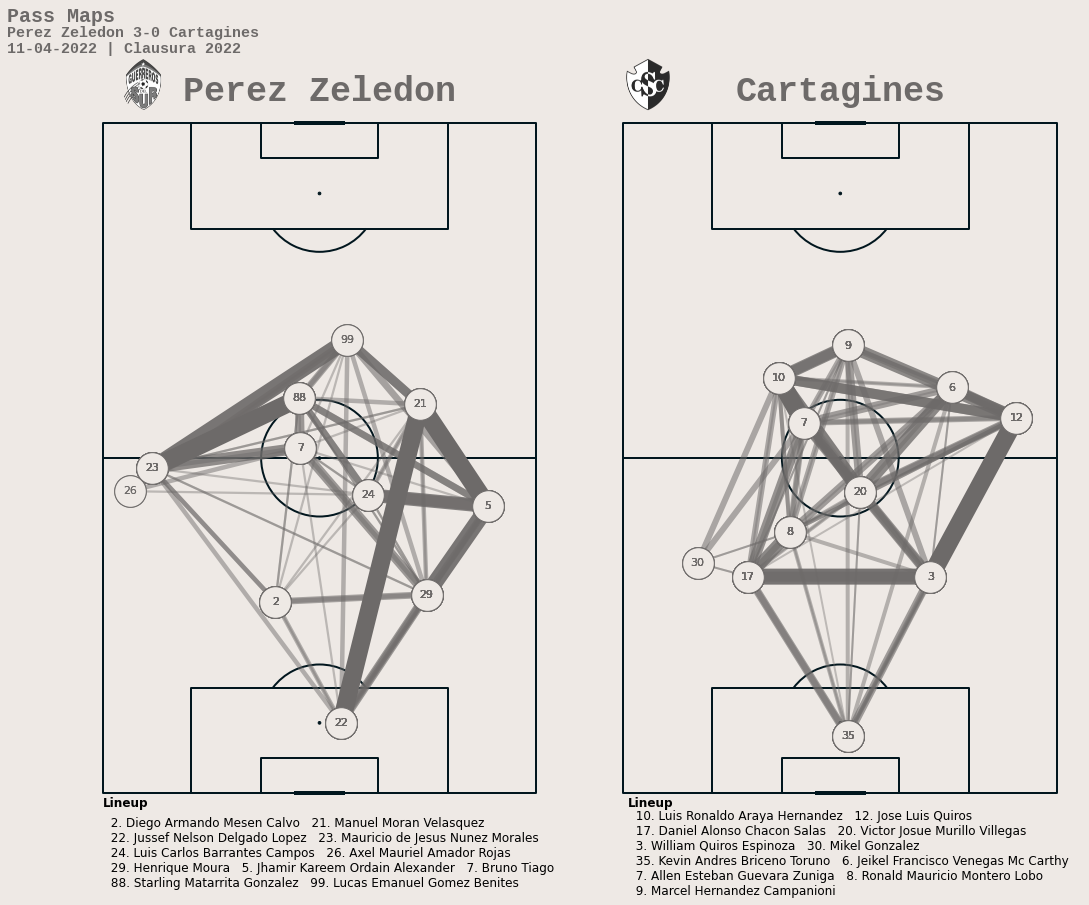

In [258]:

pass_maps('Perez-Zeledon-3-0-Cartagines','Perez Zeledon','Cartagines')



In [21]:
fm.findSystemFonts(fontpaths=None, fontext="ttf")
#!rm ~/.cache/matplotlib -rf

['/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/Liberati

In [245]:
main_df['Partido'].unique()

array(['Perez-Zeledon-1-1-Municipal-Grecia', 'Guadalupe-3-2-Cartagines',
       'Alajuelense-1-0-Guadalupe2', 'Municipal-Grecia-1-1-Herediano2',
       'Deportivo-Saprissa-1-2-San-Carlos2',
       'Cartagines-2-1-Perez-Zeledon', 'Sporting-FC-2-2-Guadalupe2',
       'Municipal-Grecia-1-0-Jicaral2',
       'Santos-de-Guapiles-0-0-Herediano2',
       'Deportivo-Saprissa-2-4-Cartagines2',
       'Alajuelense-4-0-Guanacasteca2', 'San-Carlos-1-1-Perez-Zeledon',
       'Jicaral-1-0-Santos-de-Guapile',
       'Guanacasteca-1-0-Municipal-Grecia2', 'Guadalupe-3-1-San-Carlos',
       'Cartagines-2-1-Sporting-FC2', 'Perez-Zeledon-2-1-Alajuelense2',
       'Herediano-1-1-Deportivo-Saprissa2',
       'Deportivo-Saprissa-1-2-Santos-de-Guapiles2',
       'Sporting-FC-3-0-Jicaral', 'Guanacasteca-0-0-Perez-Zeledon2',
       'Alajuelense-3-2-Cartagines2', 'Guadalupe-3-1-Municipal-Grecia',
       'San-Carlos-1-1-Herediano',
       'Santos-de-Guapiles-0-1-Perez-Zeledon2',
       'Alajuelense-0-1-Deportivo-

In [250]:
main_df.columns

Index(['ID', 'start', 'end', 'pos_x', 'pos_y', 'Partido', 'camisa', 'jugador',
       'Equipos', 'Acciones', 'Tiempo', 'fecha_partido', 'nombre_torneo',
       'equipo_casa', 'equipo_visita', 'marcador', 'goles_local',
       'goles_visita', 'rival', 'marcador_casa', 'marcador_visita',
       'detalle_marcador'],
      dtype='object')